In [ ]:
! pip install pylatexenc
! pip install qiskit

In [1]:
# initialization
import numpy as np
from numpy import pi

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
# from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer

# import basic plot tools
from qiskit.visualization import plot_histogram

from qiskit.quantum_info import Statevector

In [33]:
def encode(circuit,logicalQubit, dup1, dup2):
    circuit.cnot(logicalQubit,dup1)
    circuit.cnot(logicalQubit,dup2)
    circuit.barrier()

def error_syndrome(circuit,q0,q1,q2,ancilla1,ancilla2):
    circuit.barrier()
    # Set ancilla s1 to equal 1 iff q0!=q1
    circuit.cnot(q0,ancilla1)
    circuit.cnot(q1,ancilla1)
    # Set ancilla s2 to equal 1 iff q1!=q2
    circuit.cnot(q1,ancilla2)
    circuit.cnot(q2,ancilla2)
    circuit.barrier()

    # flip q0 if s1==1
    circuit.cnot(ancilla1,q0)
    # flip q2 if s2==1
    circuit.cnot(ancilla2,q2)

    # flip all if s1=s2=1 (basically reverses previous flips and flips q1)
    circuit.toffoli(ancilla1,ancilla2,q0)
    circuit.toffoli(ancilla1,ancilla2,q1)
    circuit.toffoli(ancilla1,ancilla2,q2)

def decode(circuit,logicalQubit, dup1, dup2):
    circuit.barrier()
    circuit.cnot(logicalQubit,dup2)
    circuit.cnot(logicalQubit,dup1)

def decode_optimize(circuit,logicalQubit, dup1, dup2):
    circuit.barrier()
    circuit.cnot(logicalQubit,dup1)
    circuit.cnot(logicalQubit,dup2)
    circuit.toffoli(dup1,dup2,logicalQubit)

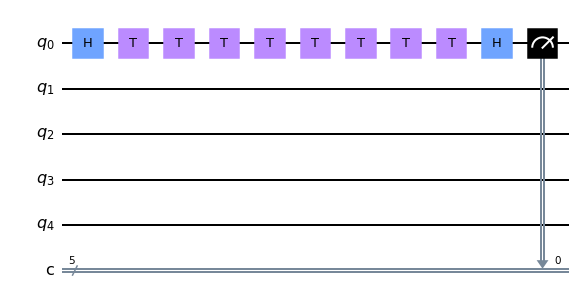

In [46]:
# Different measurements
n = 5
qreg_q = QuantumRegister(n, 'q')
creg_c = ClassicalRegister(n, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)
runWithEC = False
if runWithEC:
    encode(circuit,0,1,2)

# main circuit: should end where it started.
circuit.h(0)
circuit.t(0)
circuit.t(0)
circuit.t(0)
circuit.t(0)
circuit.t(0)
circuit.t(0)
circuit.t(0)
circuit.t(0)
circuit.h(0)

# simulate error (not needed in real HW since we have noise there already:
# circuit.x(0)

if runWithEC:
    # error_syndrome(circuit,0,1,2,3,4)
    # decode(circuit,0,1,2)
    decode_optimize(circuit,0,1,2)

circuit.measure(qreg_q[0],creg_c[0])

circuit.draw('mpl')

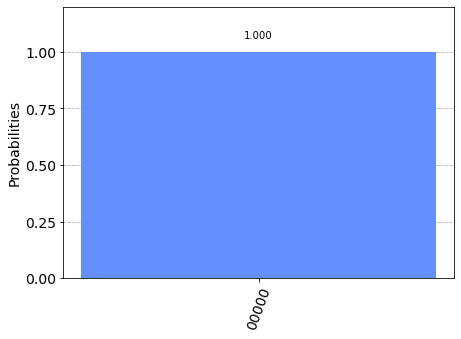

In [47]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
# shots = 1000000 # max shots
results = aer_sim.run(circuit, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [48]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n) and
                                                         not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-03-21 22:10:52,701: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


In [49]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 20000
transpiled_circuit = transpile(circuit, backend, optimization_level=0)
job = backend.run(transpiled_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run
